<a href="https://colab.research.google.com/github/rafaelsguerra/data_science_portfolio/blob/main/Comparando_intervalos_de_confian%C3%A7a_e_testes_de_hip%C3%B3tese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando testes de hipótese e intervalos de confiança em jogos do Brasileirão

O objetivo deste artigo é comparar o uso de intervalos de confiança e testes de hipótese na realização de inferências estatísticas. Os dados utilizados são do campeonato brasileiro de 2017, no qual foram realizados 380 jogos.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('https://gist.githubusercontent.com/nazareno/a8d0cbdec191f5d82095576fcff3671c/raw/60b83a812cef94297ed4bee4582d788204be7556/campeonato-brasileiro-full.csv',
                   delimiter=';')

## Intervalos de confiança

Intervalo de confiança é, como o próprio nome diz, um intervalo ou amplitude de valores que foram obtidos de ou produzidos por estatísticas de amostras dos dados da população e que têm a probabilidade de conter o valor de um parâmetro da população.

As amostras utilizadas são obtidas aleatoriamente, portanto dificilmente irão produzir intervalos idênticos. Além disso, o parâmetro da população pode não estar contido dentro do intervalo.

Para que possa ser retirada alguma conclusão, é necessário retirar várias amostras aleatórias repetidamente, de modo a obter um nível de confiança. Em outras palavras, este nível é a proporção de intervalos de confiança que contém o parâmetro de interesse.

![image](https://support.minitab.com/pt-br/minitab/19/media/notranslate/confidence_interval_def.gif)

Na imagem acima, há 20 amostras de uma população, onde cada uma produziu um intervalo de confiança e apenas um deles não contêm o parâmetro $\mu$ que representa a média populacional. Neste experimento foi utilizado um nivel de confiança de 95%, pois de 20 intervalos, 19, ou seja, 95% deles contém o parâmetro de interesse.

Neste artigo, para obter os intervalos de confiança será feito o processo de bootstraping que é um método de reamostragem cuja finalidade é estimar a distribuição das amostras.

## Testes de hipótese

Teste de hipótese é um procedimento estatístico onde deve-se aceitar ou rejeitar uma alegação ou, como o próprio nome diz, uma hipótese sobre uma população analisando as amostras obtidas.

Este teste analisa duas hipóteses: a **hipótese nula** que é a declaração que está sendo testada e a **hipótese alternativa** que é a declaração que quer ser provada baseada nos dados obtidos pelas amostras ou quando a hipótese nula não possui evidência estatística.

Em resumo, o teste determina se devemos rejeitar a hipótese nula.

Para realizar os testes, em vez de utilizar bootstraping como método de reamostragem, serão utilizadas permutações.

## Os dados

Esta é a forma de como os dados estão organizados no dataset.

In [3]:
data.head(5)

,Horario,Dia,Data,Clube 1,Clube 2,Vencedor,Rodada,Arena,p1,p2,gols,C1 Estado,C2 Estado,Vencedor Estado
0,16:00,Sábado,13/05/2017,Flamengo,Atlético-MG,-,1ª Rodada,Maracanã,1,1,2,RJ,MG,Empate
1,19:00,Sábado,13/05/2017,Corinthians,Chapecoense,-,1ª Rodada,Arena Corinthians,1,1,2,SP,SC,Empate
2,11:00,Domingo,14/05/2017,Fluminense,Santos,Fluminense,1ª Rodada,Maracanã,3,2,5,RJ,SP,RJ
3,16:00,Domingo,14/05/2017,Cruzeiro,São Paulo,Cruzeiro,1ª Rodada,Mineirão,1,0,1,MG,SP,MG
4,16:00,Domingo,14/05/2017,Ponte Preta,Sport,Ponte Preta,1ª Rodada,Moisés Lucarelli,4,0,4,SP,PE,SP


Com a visualização abaixo, podemos ver quantos jogos ocorreram em cada dia da semana.

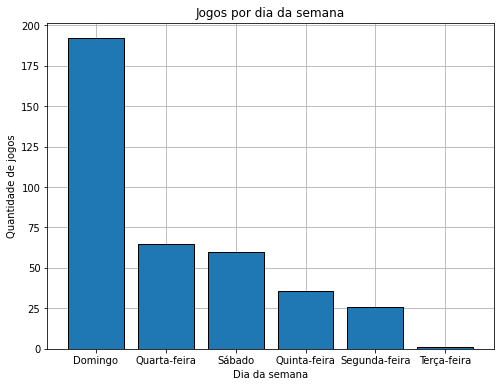

In [4]:
matches_day = data['Dia'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(matches_day.index, matches_day, zorder=3, edgecolor='black')
plt.title('Jogos por dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Quantidade de jogos')
plt.grid()
plt.show()

Observando o gráfico, é possível concluir que a grande maioria dos jogos acontecem no domingo, com quarta-feira logo depois. Levando em consideração esses dois dias da semana, podemos levantar a seguinte pergunta: **jogos aos domingos têm mais gols que jogos na quarta?** 

E aqui podemos ver em quantos jogos houve um vencedor.

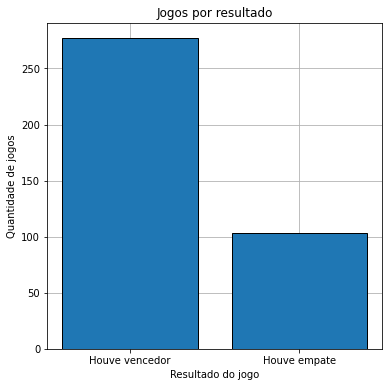

In [5]:
matches_with_winner = data[data['Vencedor'] != '-']
matches_without_winner = data[data['Vencedor'] == '-']

outcomes = {"Houve vencedor": len(matches_with_winner),
         "Houve empate": len(matches_without_winner)}

plt.figure(figsize=(6, 6))
plt.bar(outcomes.keys(), outcomes.values(), zorder=3, edgecolor='black')
plt.title('Jogos por resultado')
plt.xlabel('Resultado do jogo')
plt.ylabel('Quantidade de jogos')
plt.grid()
plt.show()

Podemos ver que, durante esta edição do campeonato, mais de 250 partidas terminaram com algum vencedor. É mais que o dobro das que terminatam empate. Se houveram tantas partidas com vencedor, é possível levantar a seguinte pergunta: **jogos onde há um vitorioso têm mais ou menos gols do que em jogos onde houve empate?**

Podemos responder as duas perguntas acima por meio de inferência estatística, utilizando intervalos de confiança e testes de hipótese. A seguir será mostrado uma maneira de como podemos realizar esses procedimentos.

## Caso 1: jogos aos domingos têm mais gols que jogos nas quartas?


### Utilizando intervalo de confiança

Primeiramente é preciso estabelecer o parâmetro que pretendemos estimar. Queremos saber se jogos aos domingos têm mais gols que jogos às quartas. É possível estimar isto comparando a média de gols dos jogos aos domingos com a média de gols dos jogos às quartas. A função abaixo irá fazer este trabalho. Uma diferença positiva significa que jogos aos domingos têm mais gols e uma negativa, jogos às quartas.

Na amostra que temos, a diferença das médias apesar de ser negativa, indicando que jogos às quartas têm mais gols, é muito proxima de zero.

In [6]:
def calculate_theta(data) :
  media_gols_domingo = np.mean(data[data["Dia"] == "Domingo"]["gols"])
  media_gols_quarta = np.mean(data[data["Dia"] == "Quarta-feira"]["gols"])

  return media_gols_domingo - media_gols_quarta

theta = calculate_theta(data)
theta

-0.014823717948718063

Retomando o que foi dito no início do artigo, iremos utilizar o processo de bootstraping. Isto nada mais é do que um processo de reamostragem com a finalidade de estimar a distribuição de um estimador. O diferencial deste tipo de reamostragem é que ela é feita **com reposição**, ou seja, é permitido que a mesma entrada da amostra original possa aparecer mais de uma vez nas amostras subsequentes obtidas. A função abaixo irá fazer este processo.

In [7]:
def bootstrapper(data):
  bootstrap = data.sample(n=len(data), replace=True)
  return calculate_theta(bootstrap)

Uma vez implementada a função, é hora de realizar a reamostragem. O processo será realizado 4000 vezes e os resultados serão guardados numa lista. Não há razão específica para este número de reamostragens, já que a própria literatura sugere vários números deferentes, podendo ser 1000, 10000, 100000 ou até mais.

In [8]:
repeat = 4000
differences = []

for i in range(repeat):
  boot_diff = bootstrapper(data)
  differences.append(boot_diff)

O histograma abaixo representa como as diferenças estão distribuídas. É possível notar claramente que elas se aproximam de uma distribuição normal.

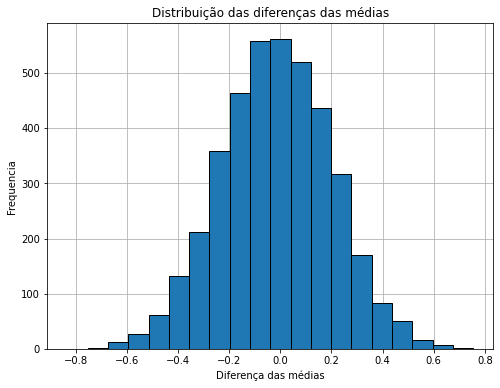

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(differences, zorder=3, edgecolor="black", bins=20)
plt.title("Distribuição das diferenças das médias")
plt.xlabel("Diferença das médias")
plt.ylabel("Frequencia")
plt.grid()
plt.show()

Agora que sabemos a distribuição dos estimadores do parâmetro, podemos calcular o intervalo de confiança. Para isto, iremos adotar um nível de confiança de 95%, ou seja, há 95% de chance de que o resultado para a população esteja dentro do intervalo obtido.



In [10]:
errors = [theta_hat - theta for theta_hat in differences]
inf_error = np.quantile(errors, 0.025)
sup_error = np.quantile(errors, 0.975)

inf_value = theta + inf_error
sup_value = theta + sup_error

interval = {"inf_value": inf_value, "sup_value": sup_value}
print(interval)

{'inf_value': -0.4414710250979511, 'sup_value': 0.4105660679652588}


Feitos os cálculos, obtivemos um intervalo de confiança que varia de aproximadamente -0,44 até aproximadamente 0,41. O gráfico abaixo ilustra este intervalo.

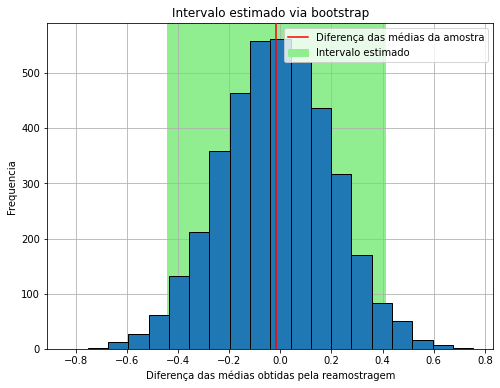

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(differences, zorder=2, edgecolor="black", bins=20)
plt.axvline(theta, zorder=3, color="red", label="Diferença das médias da amostra")
plt.axvspan(xmin=inf_value, xmax=sup_value, color="lightgreen", label="Intervalo estimado")
plt.title("Intervalo estimado via bootstrap")
plt.xlabel("Diferença das médias obtidas pela reamostragem")
plt.ylabel("Frequencia")
plt.legend()
plt.grid()
plt.show()

Podemos tomar como conclusão que, com 95% de confiança, a diferença entre a média de gols de jogos aos domingos e de jogos as quartas da população de jogos do campeonato brasileiro está entre -0,44 e 0,41. Como o intervalo passa por zero, é provável que não haja diferença alguma.

### Utilizando teste de hipótese

Para realizar este teste, iremos reformular a pergunta em duas hipóteses:
- H$_{0}$: não há diferença entre a média de gols nos domingos e a média de gols nas quartas, ou seja, a diferença é zero.
- H$_{1}$: há diferença entre a média de gols nos domingos e a média de gols nas quartas, ou seja, a diferença é diferente de zero.

Como adotamos um nível de confiança de 95% para medir o intervalo de confiança, iremos adotar um nível de significância $\alpha$ de 5%. Isso significa que há 5% chance de rejeitarmos a hipótese nula H$_{0}$ sendo ela verdadeira, o que caracteriza um erro tipo I.


Dito isso, iremos agora realizar as permutações. Realizamos um teste de permutação quando queremos obter a distribuição do parâmetro a ser calculado, assumindo que a hipótese nula seja verdadeira. Para isso calcula-se vários valores dessa estatística sob vários rearranjos dos dados observados.

In [12]:
def get_permutated_theta(data):
  d = data
  permutated_dia = list(d["Dia"].sample(n=len(data)))
  d["dia embaralhado"] = permutated_dia
  mean_goals_sunday = np.mean(d[d["dia embaralhado"] == "Domingo"]["gols"])
  mean_goals_wednesday = np.mean(d[d["dia embaralhado"] == "Quarta-feira"]["gols"])

  return mean_goals_sunday - mean_goals_wednesday

Aqui, o processo de permutação é executado 4000 vezes e as diferenças das médias são guardadas numa lista.

In [13]:
differences = []

for i in range(repeat):
  diff = get_permutated_theta(data)
  differences.append(diff)

O gráfico de denisdade abaixo ilustra a distribuição das diferenças das médias. Um gráfico de densidade é muito similar a um histograma. A curva simplesmente representa a densidade da probabilidade do que se quer medir. Ela é calculada de modo que a área abaixo da curva seja igual a 1.

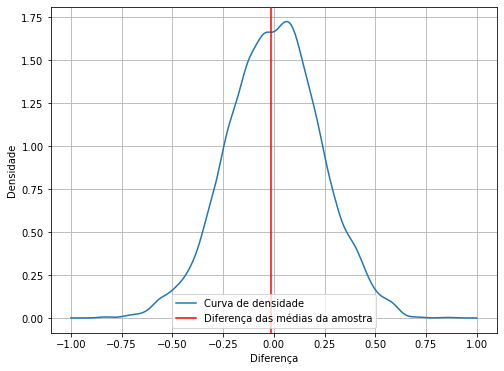

In [14]:
from scipy.stats import gaussian_kde
density = gaussian_kde(differences)
xs = np.linspace(-1, 1, 200)
density.covariance_factor = lambda : .15
density._compute_covariance()

plt.figure(figsize=(8, 6))
plt.plot(xs, density(xs), zorder=3, label="Curva de densidade")
plt.axvline(theta, zorder=3, color="red", label="Diferença das médias da amostra")
plt.xlabel("Diferença")
plt.ylabel("Densidade")
plt.legend()
plt.grid()
plt.show()

Novamente sabendo que as diferenças são distribuídas normalmente, vamos realizar os testes. As maneiras mais comuns são: determinar a região crítica ou calcular o p-valor. Como ja foram feitas reamostragens e dispomos de recursos computacionais, será feito o cálculo do p-valor.

In [15]:
p_value = np.mean([1 if abs(diff) >= abs(theta) else 0 for diff in differences])
p_value

0.953

Como o p valor é muito superior ao nível de significância e é bem próximo de 1, então deve-se **não** rejeitar a hipótese nula, ou seja, não existem evidências amostrais suficientes que apontem uma diferença entre a média de gols nos domingos e a média de gols nas quartas.

## Caso 2: jogos onde há um vitorioso têm mais ou menos gols que empates?

### Utilizando intervalo de confiança

De forma semelhante à pergunta anterior, estamos interessados em saber se há mais gols em jogos com vitórias do que em empates. Uma forma de obter uma resposta é calculando a média de gols de cada resultado e depois tirar a diferença. Neste caso, uma diferença positiva significa que há mais gols em jogos onde houve um vencedor, enquanto que uma diferença negativa significa que há mais gols em jogos onde houve empate.

Na amostra que temos, há uma diferença positiva de aproximadamente 0.56 gol.

In [16]:
def calculate_theta(data):
  mean_goals_winner = np.mean(data[data["Vencedor"] != "-"]["gols"])
  mean_goals_draw = np.mean(data[data["Vencedor"] == "-"]["gols"])

  return mean_goals_winner - mean_goals_draw

theta = calculate_theta(data)
theta

0.5618099610949492

Aqui novamente realizamos o processo de bootstrping com 4000 repetições e armazenamos as diferenças obtidas numa lista.

In [17]:
def bootstrapper(data):
  bootstrap = data.sample(n = len(data), replace=True)
  return calculate_theta(bootstrap)

repeat = 4000
differences = []

for i in range(repeat):
  boot_diff = bootstrapper(data)
  differences.append(boot_diff)

O histograma abaixo permite identificar que as diferenças estão distribuídas normalmente. As diferenças próximas de 0.6 são as mais comuns.

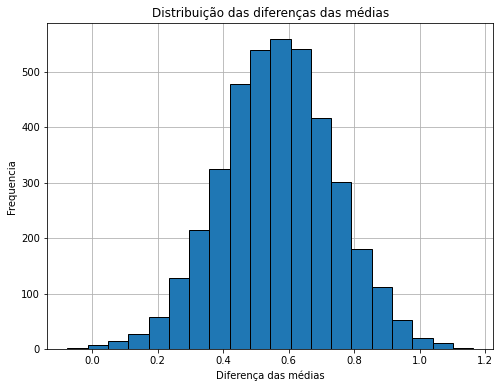

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(differences, zorder=3, edgecolor="black", bins=20)
plt.title("Distribuição das diferenças das médias")
plt.xlabel("Diferença das médias")
plt.ylabel("Frequencia")
plt.grid()
plt.show()

Agora que sabemos a distribuição das médias, podemos calcular o intervalo de confiança, assumindo um nível de confiança de 95%.

In [19]:
errors = [theta_hat - theta for theta_hat in differences]
inf_error = np.quantile(errors, 0.025)
sup_error = np.quantile(errors, 0.975)

inf_value = theta + inf_error
sup_value = theta + sup_error

interval = {"inf_value": inf_value, "sup_value": sup_value}
print(interval)

{'inf_value': 0.22103888832332264, 'sup_value': 0.9022302813590866}


Obtivemos um intervalo que varia de aproximadamente 0.22 até 0.90. O gráfico abaixo ilustra este intervalo.

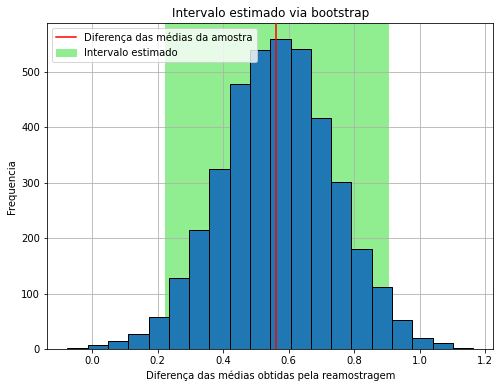

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(differences, zorder=2, edgecolor="black", bins=20)
plt.axvline(theta, zorder=3, color="red", label="Diferença das médias da amostra")
plt.axvspan(xmin=inf_value, xmax=sup_value, color="lightgreen", label="Intervalo estimado")
plt.title("Intervalo estimado via bootstrap")
plt.xlabel("Diferença das médias obtidas pela reamostragem")
plt.ylabel("Frequencia")
plt.legend()
plt.grid()
plt.show()

Podemos então concluir que, assumindo um nível de confiança de 95%, a real diferença entre a média de gols de jogos onde houve um vencedor e a média de gols de jogos onde houve empate está entre 0.22 e 0.90. Como o intervalo não passa por 0 e é sempre positivo, podemos dizer que há mais gols em jogos com um vitorioso.

### Utilizando teste de hipótese

Primeiramente vamos reformular a pergunta em duas hipóteses:
- H$_{0}$: não há diferença de gols entre jogos com um vitorioso e jogos com empate.
- H$_{1}$: há diferença de gols entre jogos com um vitorioso e jogos com empate.

Considerando um nível de significância $\alpha$ de 5%, vamos realizar as permutações e armazenar as diferenças das médias obtidas por elas numa lista.

In [21]:
def calculate_theta_shuffled(data):
  d = data
  vencedor_sample = list(d["Vencedor"].sample(n=len(data)))
  d["vencedor_perm"] = vencedor_sample
  mean_goals_winner = np.mean(d[d["vencedor_perm"] != "-"]["gols"])
  mean_goals_draw = np.mean(d[data["vencedor_perm"] == "-"]["gols"])

  return mean_goals_winner - mean_goals_draw
  
differences2 = []

for i in range(repeat):
  diff = calculate_theta_shuffled(data)
  differences2.append(diff)

O gráfico de densidade a abaixo ilustra como as diferenças estão distribuídas. Mesmo com o processo de permutação, as diferenças ainda seguem uma distribuição normal.

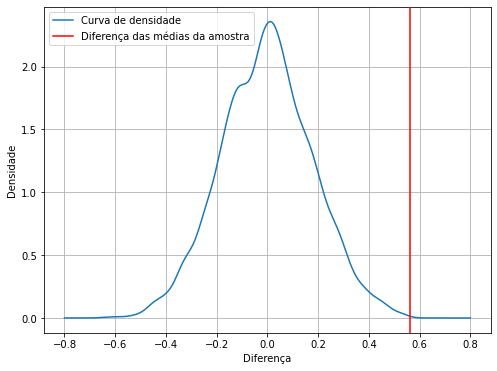

In [22]:
density = gaussian_kde(differences2)
xs = np.linspace(-0.8, 0.8, 200)
density.covariance_factor = lambda : .15
density._compute_covariance()

plt.figure(figsize=(8, 6))
plt.plot(xs, density(xs), zorder=3, label="Curva de densidade")
plt.axvline(theta, zorder=3, color="red", label="Diferença das médias da amostra")
plt.xlabel("Diferença")
plt.ylabel("Densidade")
plt.legend()
plt.grid()
plt.show()

Com as diferenças obtidas realizando permutações 4000 vezes, podemos calcular o p-valor.

In [23]:
p_value = np.mean([abs(diff) >= abs(theta) for diff in differences2])
p_value

0.00075

Neste caso, o p-valor é bem próximo de zero e é menor que o nível de significância. Desse modo, podemos **rejeitar** a hipótese nula, ou seja, há evidências amostrais suficientes para afirmar que exite uma diferença entre a média de gols de jogos que possuem um vencedor e a média de gols de jogos empatados.

## Considerações finais

Avaliando os resultados das duas perguntas podemos concluir que intervalos de confiança e testes de hipótese são processos bastante poderosos para realizar inferenência estatística. Ambos trouxeram resultados equivalentes e complementam um ao outro.